https://blog.csdn.net/iteapoy/article/details/106496287
# RNN自然语言生成
输入一个国家的语言名，和名字的首字母缩写，模型自动生成名字

示例:
```shell
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov
```

## 预处理
`n_letters` 表示字母表的长度。加入一个特殊符号 `<EOS>`,表示文本生成结束,当生成 `<EOS>` 的时候，就结束RNN的循环。

用`unicodeToAscii()`函数将某些语言的特殊字符转换为Ascii码

In [1]:
from io import open
import glob
import os
import unicodedata
import string

# 生成字母表
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # 加上一个 EOS 标记

def findFiles(path): return glob.glob(path)

# 将unicode转换为plain Ascii码
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 读入文件 filename, 每行存储为为一项,并转化为Ascii码
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 建立一个词典 键值对为 语言类别:名字数组
# category_lines = {category: lines} , lines = [names...]
category_lines = {}
all_categories = []
# 读入所有数据文件
for filename in findFiles('data/names/*.txt'):
    # 获取分类名,名字,存入字典
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0 :
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))


# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


转化为tensor,进行one-hot编码
- `inputTensor()`函数：对输入的单词 line 进行one-hot 编码，大小为 < line_length × 1 × n_letters >

- `categoryTensor()`函数：对类别进行 one-hot 编码，大小为 <1 x n_categories> ，和$x^t,h^{t-1}$拼接到一起成为$[category, x^t, h^{t-1}]$作为RNN的输入

- `targetTensor()`函数：把目标值转换成Tensor，目标值不是 one-hot 编码，只是一个存储索引的序列

文本生成的过程：每一步，根据当前输入的字母，预测下一步输出的字母。在这里，预测得到的字母就是生成的字母。

### 创建样本
训练样本是 `input - target` 对。
例如，对样本 “`ABCD`”
- 首先，加上结束标记 “`<EOS>`” ，变成 “`ABCD<EOS>`”
- 然后，前一个字母是`input`，后一个字母是`target`，就可以创建成 (“`A`”, “`B`”), (“`B`”, “`C`”), (“`C`”, “`D`”), (“`D`”, “`<EOS>`”) 的样本对。 

`input` 是one-hot 编码，`target` 则是普通的索引，可以看成是一个从 `n_letters` 到 `n_letters` 的多分类任务。比如：

- `(“A”, “B”) = ([1,0,0,0,…,0,0],1)`
- `(“B”, “C”) = ([0,1,0,0,…,0,0],2)`
- `(“C”, “D”) = ([0,0,1,0,…,0,0],3)`
- `(“D”, “<EOS>”) = ([0,0,0,1,…,0,0],4)`

In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# category 的 one-hot编码
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor.to(device)

# input 的 one-hot编码 ，从第一个字母到最后一个字母（不包含 EOS）
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor.to(device)

# output 的 one-hot编码 ，从第二个字母到最后的 EOS 符
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li])for li in range(1,len(line))]
    letter_indexes.append(n_letters - 1) # EOS的索引
    return torch.LongTensor(letter_indexes).to(device)


cuda:0


In [3]:
import random

# 从数组 l 中随机选一个元素
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

# 随机采样一个 category，从该 category 中随机采样一个姓名line
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# 从一个随机采样的 category-line 对中构建训练样本，
# 包含 category 的tensor, input 的 tensor, 和 target 的 tensors 
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor


## 模型
搭建本次任务的RNN模型，与RNN1不同的是:
这次多了一个 o2o 层，并且用一个 dropout 层来防止过拟合。

- `input_combined = torch.cat((category, input, hidden),1)`：拼接得到$[category, x^t, h^{t-1}]$
- `hidden = self.i2h(input_combined)`：$h^t= W_h[category, x^t, h^{t-1}]$
- `output = self.i2o(input_combined)`：$o^t=W_{o1}[category, x^t, h^{t-1}]$
- `output_combined = torch.cat((hidden, output), 1)`：${o^t}' = [h^t, o^t]$
- `output = self.o2o(output_combined)`：$o^t = W_{o2}{o^t}'=W_{o2}[h^t, o^t]$
- `output = self.dropout(output)`：用 dropout 防止过拟合
- `output = self.softmax(output)`：用 softmax 把 $o^t$ 转化成预测字母的概率分布$y^t$


In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__() 
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size).to(device)


## 训练
在分类任务中，只用到了最后一步的 output   
但是在本次的文本生成任务中，要用到每一步的 output ，所以，在每一步都计算损失loss.

output 最后一层经过了 LogSoftmax，所以对应的损失函数依然是NLLLoss()
学习率设置为0.0005


In [5]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)


In [6]:
import time

def timeSince(since):
    now = time.time()
    s = now-since
    return '%dm %ds'%(s//60,s%60)

n_iters = 100000
print_every = 5000
plot_every = 500

all_losses = []
total_loss = 0

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_letters)
rnn = rnn.to(device)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % 
          (timeSince(start),iter, iter/n_iters*100,loss))
    
    if iter % plot_every == 0:
        all_losses.append(total_loss/plot_every)
        total_loss = 0


0m 25s (5000 5%) 3.3489
0m 50s (10000 10%) 2.9638
1m 15s (15000 15%) 2.5191
1m 40s (20000 20%) 2.8835
2m 5s (25000 25%) 1.7875
2m 30s (30000 30%) 2.4752
2m 56s (35000 35%) 2.5013
3m 21s (40000 40%) 2.2489
3m 47s (45000 45%) 2.9162
4m 13s (50000 50%) 2.2067
4m 39s (55000 55%) 2.3462
5m 5s (60000 60%) 1.7693
5m 30s (65000 65%) 2.4698
5m 56s (70000 70%) 1.8680
6m 22s (75000 75%) 2.3637
6m 48s (80000 80%) 1.9290
7m 14s (85000 85%) 2.3738
7m 39s (90000 90%) 1.8064
8m 5s (95000 95%) 2.2696
8m 29s (100000 100%) 2.5106


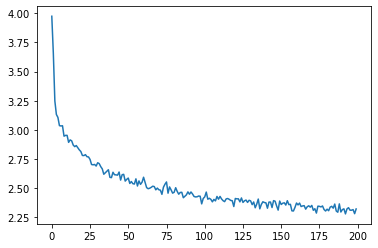

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


## 预测
给定模型一个首字母，然后模型生成下一个字母，不断重复，直到遇到 “`<EOS>`”标记符，停止生成。

- 创建输入类别category的tensor，开始字母的 tensor 和 初始化隐藏层状态$h^0$
- 用首字母生成一个字符串 output_name
- 在到达最大输出长度前：
    - 给模型输入当前的字母
    - 模型生成下一个字母，和下一个隐藏层状态
    - 如果生成的字母是 “`<EOS>`”标记符， 停止生成
    - 如果生成的字母是一个常规的字母，把它加入 output_name，并且继续生成
- 返回最终生成的名字 output_name

In [22]:
max_length = 20

def sample(category, start_letter = 'A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
    
        output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn(category_tensor,input[0],hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1 :
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = inputTensor(letter)

    return output_name

def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category,start_letter))
    print()

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'XIA')

samples('Japanese', 'XRA')


Rakilov
Uoverin
Shaki

Ganger
Erane
Roulle

Sara
Para
Alara

Xuag
Iun
Aha

Xaka
Roukas
Araka



In [23]:
samples('Spanish', 'S')

Sara

